<img src="https://storage.googleapis.com/kaggle-organizations/1076/thumbnail.jpg%3Fr=260" alt="Mercari Kaggle Competition" height="250" width="250">

# Mercari Price Suggestion Challenge
***

## Challenge description

**Problem:** It can be hard to know how much something’s really worth. Small details can mean big differences in pricing. Product pricing gets even harder at scale, considering just how many products are sold online. Clothing has strong seasonal pricing trends and is heavily influenced by brand names, while electronics have fluctuating prices based on product specs.

Mercari, Japan’s biggest community-powered shopping app, knows this problem deeply. They’d like to offer pricing suggestions to sellers, but this is tough because their sellers are enabled to put just about anything, or any bundle of things, on Mercari's marketplace.

**How to solve it:** In this competition, Mercari’s challenging you to build an algorithm that automatically suggests the right product prices. You’ll be provided user-inputted text descriptions of their products, including details like product category name, brand name, and item condition.

## Evaluation

The evaluation metric for this competition is **Root Mean Squared Logarithmic Error (RMSLE)**.

The RMSLE is calculated as:

$$ϵ=\sqrt{\frac{1}{n} \sum\limits_{i=1}^{n}{(log(p_{i}+1)-log(a_{i}+1))^2}}$$

Where:

* $ϵ$ is the RMSLE value,
* $n$ is the total number of observations in the data set,
* $p_{i}$ is your prediction of price, and
* $a_{i}$ is the actual sale price for i;
* $log(x)$ is the natural logarithm of x.

## Data

### File: train.tsv

This file consists of a list of product listings. This file is tab-delimited and includes the following variables:

* `train_id` - the id of the listing
* `name` - the title of the listing. Note that the data was cleaned in order to remove text that look like prices (e.g. \$20) to avoid leakage. These removed prices are represented as [rm]
* `item_condition_id` - the condition of the items provided by the seller
* `category_name` - category of the listing
* `brand_name` - the product's brand
* `price` - the price that the item was sold for. This is the target variable that we will predict. The unit is USD
* `shipping` - 1 if shipping fee is paid by seller and 0 by buyer
* `item_description` - the full description of the item. Note that the data was cleaned in order to remove text that look like prices (e.g. \$20) to avoid leakage. These removed prices are represented as [rm]

<br>For more information about this challenge, please visit https://www.kaggle.com/c/mercari-price-suggestion-challenge/overview.

<img src="https://erinsinsidejob.com/wp-content/uploads/2016/01/mercari.gif">

# Table of Contents
***

## 1. Define

<ul>
<li><a href="#define">Define the problem</a></li>
</ul>

## 2. Discover

<ul>
<li><a href="#obtain">Obtain data</a></li>
<li><a href="#clean">Clean data</a></li>
<li><a href="#explore">Explore data</a></li>
<li><a href="#establish">Establish baseline outcomes</a></li>
<li><a href="#hypothesize">Hypothesize solutions</a></li>
</ul>

## 3. Develop

<ul>
<li><a href="#engineer">Engineer features</a></li>
<li><a href="#modeling">Create models</a></li>
<li><a href="#modeling">Test models</a></li>
<li><a href="#select">Select best model</a></li>
</ul>

## 4. Deploy

<ul>
<li><a href="#automate">Automate pipeline</a></li>
<li><a href="#deploy">Deploy solution</a></li>
</ul>

***
<a id='define'></a>
## Define the problem

* What is the problem?

>Almost everything can be sold online, but it can be extremely difficult to determine a reasonable price for any given product.

* How do we solve it?

>Our goal is to build an algorithm that automatically suggests the right product prices for both the sellers and the buyers. This is a regression problem and we will be using RMSLE as the evaluation metric.

* Why does it matter?

>Solving this problem means that everyone's happy! The **seller will be able to sell products more effectively** since he will know beforehand what is the suggested price for the product he's trying to sell. The **buyer will know that he's paying a reasonable price** for what he's getting. And **Mercari will have more satisfied customers**. And more satisfied customers means more profit.

***
<a id='obtain'></a>
## Obtain data

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
# import data and check first few lines
df_train = pd.read_csv('./train.tsv', sep = '\t')
df_train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [3]:
# number of rows and columns of our dataframe
df_train.shape

(1482535, 8)

In [4]:
# check some details about our dataframe with the .info() method
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [5]:
# check numerical features
df_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
train_id,1482535.0,741267.000000,427971.135004,0.0,370633.5,741267.0,1111900.5,1482534.0
item_condition_id,1482535.0,1.907380,0.903159,1.0,1.0,2.0,3.0,5.0
price,1482535.0,26.737516,38.586066,0.0,10.0,17.0,29.0,2009.0
shipping,1482535.0,0.447274,0.497212,0.0,0.0,0.0,1.0,1.0


In [6]:
# check categorical features
df_train.describe(include='object').transpose()

,count,unique,top,freq
name,1482535,1225273,Bundle,2232
category_name,1476208,1287,"Women/Athletic Apparel/Pants, Tights, Leggings",60177
brand_name,849853,4809,PINK,54088
item_description,1482531,1281426,No description yet,82489


> * The training set has almost 1.5 million rows and 8 columns (variables)
* From the 8 variables, 4 are numerical (train_id, item_condition_id, price,  and shipping) and 4 are categorical (name, category_name, brand_name, and item_description)
* The average price is almost \$27 but 3/4 of the products cost \$29 or less
* There are 4809 unique brands
* The most frequent product is women pants, tights or leggins
* More than 82000 products have no description ('No description yet')

<a id='clean'></a>
## Clean data

**Note:** To speed things up, and since our dataset is quite big, we will sample 10% of it and use this sample for the rest of our analysis. All the logical reasoning behind our analysis remains valid for our dataset as a whole, even though the numbers might change.

In [7]:
df_train_sample = df_train.sample(frac=0.1, random_state=42).reset_index(drop=True)
df_train_sample.shape

(148254, 8)

Our "new" dataset has 148254 rows and 8 columns.

In [8]:
# check missing values
df_train_sample.isnull().sum().sort_values(ascending=False)

brand_name           63108
category_name          609
item_description         1
shipping                 0
price                    0
item_condition_id        0
name                     0
train_id                 0
dtype: int64

In [9]:
n_missing = df_train_sample.isnull().sum().sort_values(ascending=False)
percent_missing = (df_train_sample.isnull().sum()/len(df_train_sample)).sort_values(ascending=False)

missing_values = pd.concat([n_missing, percent_missing], axis=1, keys=['n', '%'])
missing_values

,n,%
brand_name,63108,0.425675
category_name,609,0.004108
item_description,1,0.000007
shipping,0,0.000000
price,0,0.000000
item_condition_id,0,0.000000
name,0,0.000000
train_id,0,0.000000


Three of our features have missing values. 

In the case of `brand_name`, no brand was specified for a high percentage of products (more than 40%). It is possible that the sellers did not know the brand of the product they were trying to sell. We can consider this value to be **'unknow'**.

As for `category_name`, only a small percentage of produts have a missing value for this particular variable. Let's impute it as **'Other'**.

Regarding `item_description`, there's only one missing value. We can impute this value with **'No description yet'**.

In [10]:
# Create a function to impute missing values
def impute_missing_value(df):
    df['category_name'].fillna(value = 'Other', inplace=True)
    df['brand_name'].fillna(value = 'unknown', inplace=True)
    df['item_description'].fillna(value = 'No description yet', inplace=True)

    return df

In [11]:
# check if there are still missing values
impute_missing_value(df_train_sample)
df_train_sample.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
dtype: int64

Our data does not have any missing values. We can proceed to the next step.

<a id='explore'></a>
## Explore data - EDA

### Univariate Analysis 

In [12]:
# columns labels
df_train_sample.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description'],
      dtype='object')

Let's examine our dependent variable, `price`, i. e., what we are trying to predict.

In [13]:
df_train_sample['price'].describe()

count    148254.000000
mean         26.940912
std          38.921517
min           0.000000
25%          10.000000
50%          17.000000
75%          30.000000
max        2004.000000
Name: price, dtype: float64

At first glance, two things caught my attention:
* this variable distribution seems to be **highly skewed to the right**
* the **minimum value for price is zero**, which is odd considering that users are selling products and not giving them away

Let's confirm the first point graphically.

C:\Users\joaon\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


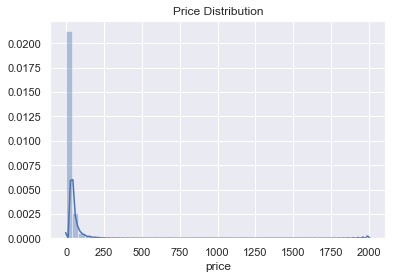

In [14]:
# histogram of dependent variable price
sns.set()
sns.distplot(df_train_sample['price'], bins = 50)
plt.title('Price Distribution', fontsize=12);

As the great majority of values for price is lower than \$250, let's limit the possible values for x.

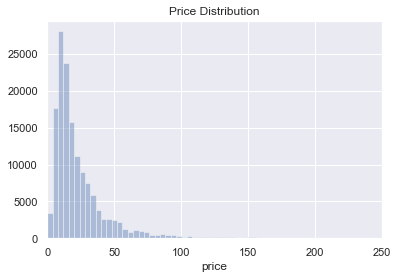

In [15]:
plt.xlim(0, 250)
sns.distplot(df_train_sample['price'], kde=False, bins = 500)
plt.title('Price Distribution', fontsize=12);

In [16]:
#skewness
stats.skew(df_train_sample['price'])

10.802715269945242

As we suspected, the **distribution for price has a long right tail** and is highly skewed. To address this problem, we can apply a **log transformation** to this variable.

C:\Users\joaon\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


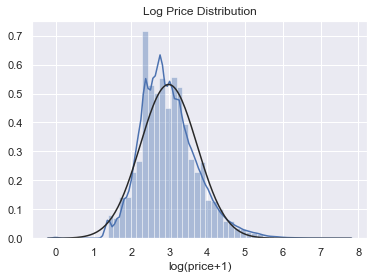

In [17]:
sns.distplot(np.log(df_train_sample['price']+1), fit = stats.norm)
plt.xlabel('log(price+1)', fontsize=12)
plt.title('Log Price Distribution', fontsize=12);

In [18]:
stats.skew(np.log(df_train_sample['price']+1))

0.6685968520865843

This distribution is now **closer to a normal distribution**, and the **skewness value is closer to zero**.

As for the minimum value of price, let's investigate this further.

In [19]:
df_train_sample[df_train_sample['price'] == 0].head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
93,84726,Sparkly Deer Bow Mint Tshirt Southern M,3,Women/Tops & Blouses/T-Shirts,unknown,0.0,1,Very gently used. Sparkly in back. It's a girl...
1289,1100976,Benefit Boing Airbrush Concealer,2,Beauty/Makeup/Eyes,Benefit,0.0,1,New (very slight swatch on left) Auth Full Siz...
1653,535205,Bundled For brittDashipeesinger,3,Kids/Boys (4+)/Coats & Jackets,Nike,0.0,0,Black hoodie Gray and orange hoodie Pink Ultim...
2076,156671,Juicy Couture Boots,4,Women/Shoes/Boots,Juicy Couture,0.0,0,1 pompom missing on lace Not sure what the act...
2756,428948,New 10pcs Brushes set,1,Beauty/Tools & Accessories/Makeup Brushes & Tools,unknown,0.0,0,Brush Length : about 15.5cm Handle the Diamete...


In [20]:
len(df_train_sample[df_train_sample['price'] == 0])

87

87 products have their price set to zero. As there seems to be no reason for this, we'll remove these items from our dataset.

In [21]:
# removing items with price = 0
df_train_sample.drop(df_train_sample[df_train_sample['price'] == 0].index, inplace=True)

In [22]:
len(df_train_sample[df_train_sample['price'] == 0])

0

In [23]:
df_train_sample.shape

(148167, 8)

We have removed items with price = 0 and now our dataset has 148167 rows.

It is now time to **examine our independent variables**.

#### For `item_condition` and `shipping`:

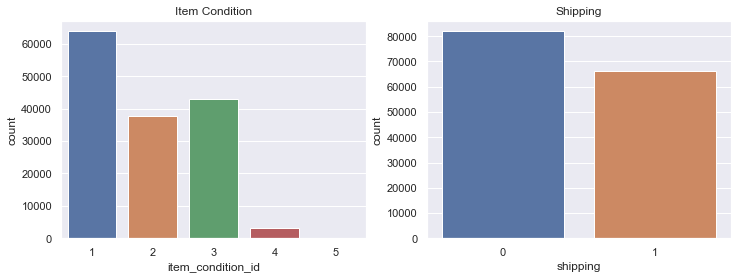

In [24]:
# countplot of independent variables item_condition_id and shipping
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.countplot(df_train_sample['item_condition_id'])
plt.title('Item Condition', fontsize=12)

plt.subplot(1, 2, 2)
sns.countplot(df_train_sample['shipping'])
plt.title('Shipping', fontsize=12);

In [25]:
pd.set_option('max_colwidth', 80)
df_train_sample[df_train_sample['item_condition_id'] == 5]['item_description'].head(10)

310     This is the best purse as far as size and the way it fits on the arm. It's n...
674     I had this PSP from my brother,he gave it to me as a birthday gift since 200...
866     REDUCED AGAIN!! Brand new with FLAWS. Damaged when delivered. Right Lens cam...
1765    8GB iPhone 5c in green. There is something wrong with the front light sensor...
2007    3 pair... These Jeans have multiple flaws including most buttons gone on bac...
2145         Grey knit ugg boots size 10 very used but still a little life left in them
2298    cracked white iphone 5s silver. works fine. will come with brand new duracel...
2318                                                  Clean imei. Can be used for parts
3770    The touch is badly broken/cracked- iPod classic has been off for a while- ch...
4313                 Nike Little Posite One PS size 13c size 13 c flaws in the pictures
Name: item_description, dtype: object

In [26]:
df_train_sample[df_train_sample['item_condition_id'] == 1]['item_description'].head(10)

0     This listing is for all 4 Totoro washi tape for a limited time offer you als...
1                           7 items. 1: XL. 2: 2XL. 3:2XL. 4: XL. 5: 2XL. 6: OS 7: 38
2                                                        - sunglasses and necklace :)
3                I ordered a bunch of stickers so you will recieve many cute ones! :)
8                                                                           10/10 New
9     High quality Immediate purchase Ok? Free shipping 1.Detail: Necklace Type:Pe...
10              Starbucks drink cards l. Ask for bundle and will try to work with you
11                                                Color in Vintage. New and unopened.
12    Brand new in packaging Soft and slow rising Smells like strawberry May have ...
13    New Travel Size No box Fresh Soy Face Cleanser 20 ml New Travel Size Fresh F...
Name: item_description, dtype: object

In [27]:
df_train_sample['item_condition_id'].value_counts(sort=False) / len(df_train_sample)

1    0.431142
2    0.254929
3    0.290294
4    0.022070
5    0.001566
Name: item_condition_id, dtype: float64

Considering the item descriptions and the information available at https://www.mercari.com/help_center/article/316/:
* **more than 40%** of the articles are considered to be **new**
* around **25%** are **like new**
* a little less than **30%** are **good**
* only around **2,5%** of the articles are considered to be **fair** or **poor**.

In [28]:
df_train_sample['shipping'].value_counts() / len(df_train_sample)

0    0.553349
1    0.446651
Name: shipping, dtype: float64

As for the shipping, in around **55%** of the cases the **shipping is paid by the buyer**. **45%** of the times the **seller pays for the shipping**.

#### For `brand_name` and `category_name`:

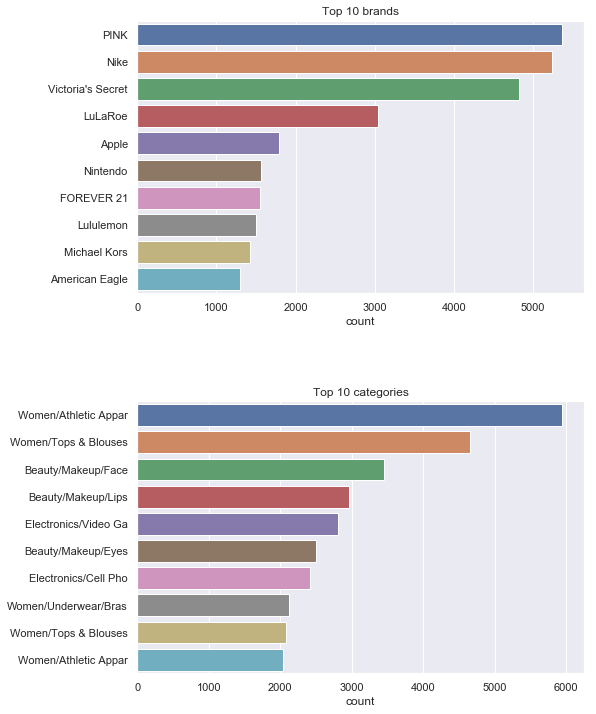

In [30]:
# barplot of Top10 brands and categories
plt.figure(figsize=(8, 12))
plt.subplots_adjust(hspace = 0.4)

plt.subplot(2, 1, 1)
sns.barplot(y=df_train_sample['brand_name'].value_counts()[1:11].index, 
            x=df_train_sample['brand_name'].value_counts()[1:11])
plt.xlabel('count', fontsize=12)
plt.title('Top 10 brands', fontsize=12)

plt.subplot(2, 1, 2)
sns.barplot(y=df_train_sample['category_name'].value_counts()[:10].index, 
            x=df_train_sample['category_name'].value_counts()[:10])
plt.xlabel('count', fontsize=12)
# reduce y-labels to the first 20 characters
ylabels_20 = [df_train_sample['category_name'].value_counts()[:10].index[i][0:20] for i in range(10)]
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], labels=ylabels_20)
plt.title('Top 10 categories', fontsize=12);

In [31]:
# Top10 brands (counting from 1 because 0 corresponds to 'unknown')
df_train_sample['brand_name'].value_counts()[1:11]

PINK                 5375
Nike                 5237
Victoria's Secret    4822
LuLaRoe              3042
Apple                1789
Nintendo             1558
FOREVER 21           1554
Lululemon            1496
Michael Kors         1419
American Eagle       1293
Name: brand_name, dtype: int64

The **top 3 brands** are all from the **clothing and footwear industry** and clearly dominate over the other brands. In number 4 but at a certain distance, we have another brand from the clothing industry. Ranking **5th and 6th**, we have two brands from the **consumer electronics** sector, and other brands follow closely.

In [32]:
df_train_sample['category_name'].value_counts()[:10]

Women/Athletic Apparel/Pants, Tights, Leggings                 5949
Women/Tops & Blouses/T-Shirts                                  4653
Beauty/Makeup/Face                                             3450
Beauty/Makeup/Lips                                             2961
Electronics/Video Games & Consoles/Games                       2803
Beauty/Makeup/Eyes                                             2503
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    2417
Women/Underwear/Bras                                           2125
Women/Tops & Blouses/Blouse                                    2078
Women/Athletic Apparel/Shorts                                  2037
Name: category_name, dtype: int64

Regarding the categories, **women clothes and makeup** clearly dominate the top 10. The exceptions are products from the sub-category **Video Games & Consoles** (5th) and **Cell Phones and Accessories** (7th), both from the consumer electronics industry.

### Bivariate Analysis

#### Relationship between `price` and `item_condition_id`

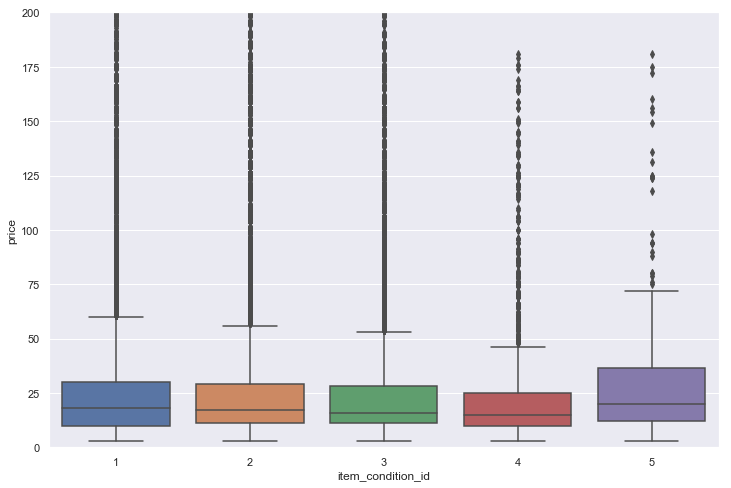

In [33]:
plt.figure(figsize=(12, 8))

sns.boxplot(x='item_condition_id', y="price", data=df_train_sample)
plt.ylim(0, 200);

As one would expect, the **median price decreases as item_condition_id increases** (1: new, 2: like new, 3: good, 4: fair). The **exception is 5: poor**. Let's examine this closely.

In [34]:
df_train_sample[df_train_sample['item_condition_id'] == 5]['price'].describe()

count    232.000000
mean      32.797414
std       35.499374
min        3.000000
25%       12.000000
50%       20.000000
75%       36.500000
max      181.000000
Name: price, dtype: float64

In [35]:
df_train_sample[df_train_sample['item_condition_id'] == 5]['category_name'].value_counts()[:5]

Electronics/Cell Phones & Accessories/Cell Phones & Smartphones    64
Electronics/Video Games & Consoles/Games                           17
Electronics/Video Games & Consoles/Consoles                        15
Men/Shoes/Athletic                                                 12
Electronics/Computers & Tablets/Laptops & Netbooks                  7
Name: category_name, dtype: int64

Several reasons can explain this issue:
* some sellers may have **wrongly defined the condition of the product**, assuming that 5 corresponds to new (as it is the higher value) instead of 1
* as it is such a **small category** (only 232 products in total), there can be some **bias** associated with it
* contrary to other categories, the **top 5 products** of this category are from the **consumer electronics industry (4) and men footwear (1)**, making this category diffcult to compare with the others

### Multivariate Analysis

#### `price`, `item_condition_id` and `category_name`

C:\Users\joaon\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


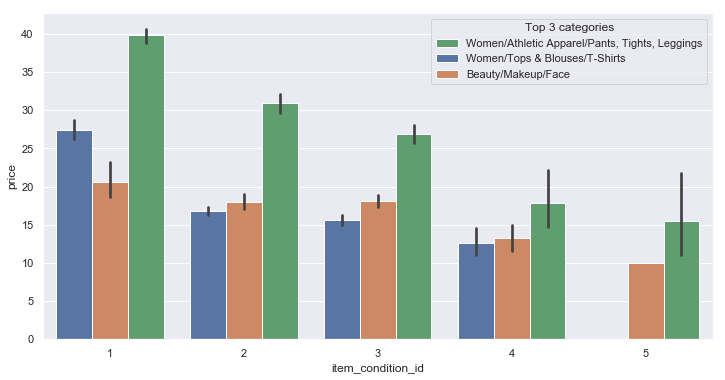

In [36]:
plt.figure(figsize=(12, 6))
sns.barplot(x='item_condition_id', y="price", hue='category_name', data=df_train_sample[(df_train_sample['category_name'] == df_train_sample['category_name'].value_counts().index[0]) | (df_train_sample['category_name'] == df_train_sample['category_name'].value_counts().index[1]) | (df_train_sample['category_name'] == df_train_sample['category_name'].value_counts().index[2])])
handles, labels = plt.gca().get_legend_handles_labels()
handles = [handles[2], handles[0], handles[1]]
labels = [labels[2], labels[0], labels[1]]
plt.legend(handles, labels, title='Top 3 categories', loc='upper right');

Plotting a bar plot for `item_condition_id` and `price` adding a third variable as a hue semantic - `category_name` - for the top 3 categories, we confirm the pattern we have previously identified: the **average price decreases as item_condition_id increases**. We can also see that the **average price is higher for the top category - *Women/Athletic Apparel/Pants, Tights, Leggings* **- no matter what the item condition is.

<a id='establish'></a>
## Establish baseline outcomes

Sellers can put just about anything for sale on Mercari's marketplace, but usually **it is hard to know the real worth of something**. What happens today is that **sellers have no assistance in defining the selling price**, and this can turn into a complicated problem to solve. Either they set the price to low and lose money or they set the price to high and cannot find a buyer for their products. We wish to improve this situation.

<a id='hypothesize'></a>
## Hypothesize solutions

Our goal is to find a way to **determine the right product prices** and make this information available both to the seller and the buyer before they sell/purchase any product.

With that in mind, we aim to **build an algorithm that automatically suggests the right product prices**. We’ll try to leverage the features that are available, including details like product category name, brand name, and item condition, as well as user-inputted text descriptions of the products.

We'll use some **natural language processing techniques** to extract useful information from those text descriptions and we will be using **RMSLE as the evaluation metric**.

***
<a id='engineer'></a>
## Engineer features

The `category_name` feature follows the format **main_category/subcategory_1/subcategory2/...** . It would be interesting to store this information in a different way, where each (sub)category is stored as an independent feature.

In [37]:
# create column "number_of_categories"
# with info about the number of categories of each product's category_name
df_train_sample['number_of_categories'] = df_train_sample['category_name'].apply(lambda x: len(x.split('/')))

In [38]:
df_train_sample['number_of_categories'].value_counts()

3    147088
1       605
5       330
4       144
Name: number_of_categories, dtype: int64

For most products, `category_name` has **3 levels**, with the format **main_category/subcategory_1/subcategory2**. One example of this is our top category, *Women/Athletic Apparel/Pants, Tights, Leggings*.

In [39]:
df_train_sample[df_train_sample['number_of_categories'] == 1]['category_name'].value_counts()

Other    605
Name: category_name, dtype: int64

The products where `category_name` has only **1 level** correspond to the ones with the value **'Other'** for this variable.

In [40]:
df_train_sample[df_train_sample['number_of_categories'] == 4]['category_name'].value_counts()

Sports & Outdoors/Exercise/Dance/Ballet            74
Sports & Outdoors/Outdoors/Indoor/Outdoor Games    35
Men/Coats & Jackets/Flight/Bomber                  28
Men/Coats & Jackets/Varsity/Baseball                7
Name: category_name, dtype: int64

In [41]:
df_train_sample[df_train_sample['number_of_categories'] == 5]['category_name'].value_counts()

Electronics/Computers & Tablets/iPad/Tablet/eBook Readers    203
Electronics/Computers & Tablets/iPad/Tablet/eBook Access     127
Name: category_name, dtype: int64

Some other products have **4 or 5 levels** for `category_name`.

Let's create a function to extract this information and store it in 5 new features:
>* main_category
* subcategory_1
* subcategory_2
* subcategory_3
* subcategory_4

In [42]:
def extract_all_categories(category_name):
    """Returns a list of the different categories.
    
    The list to be returned has a fixed length of 5.
    In cases where there aren't enough subcategories,
    the remaining elements of the list have the value 'None'.

    Args:
        category_name (str): The category name to be split.

    Returns:
        list: The list of categories.   

    """
    categories = []
    
    for i in range(len(category_name.split('/'))):
        categories.append(category_name.split('/')[i])
        
    list_with_nones = ['None'] * (4-i)
    categories.extend(list_with_nones)
    
    return categories

In [43]:
df_train_sample['main_category'], df_train_sample['subcategory_1'], df_train_sample['subcategory_2'], df_train_sample['subcategory_3'], df_train_sample['subcategory_4'] = zip(*df_train_sample['category_name'].apply(extract_all_categories))

In [44]:
# drop column "number_of_categories"
df_train_sample.drop('number_of_categories', axis = 1, inplace = True)

In [45]:
df_train_sample.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description', 'main_category',
       'subcategory_1', 'subcategory_2', 'subcategory_3', 'subcategory_4'],
      dtype='object')

It's now time to explore the `item_description` feature. Let's see how we can extract useful information from it using some **natural language processing techniques**.

<img src="https://deeplearninganalytics.org/wp-content/uploads/2019/04/nlp.png">

### NATURAL LANGUAGE PROCESSING

In order to perform machine learning on text, we need to **transform our item descriptions into vector representations**. This process is called **feature extraction or vectorization**. We need to change the way we think about text from a sequence of words to points that occupy a high-dimensional semantic space.

The simplest encoding of this semantic space is a **bag-of-words (BoW)** model based on simple counts of how many times each word appears on a given text (**frequency**). Other models include **one-hot-encoding**, **TF-IDF (Term Frequence-Inverse Document Frequency)**, and **distributed representations**.

### Text vectorization methods

>* **Frequency** - converts a text document into a flat vector (it doesn't contain any of the original text structures) and only counts term frequencies.
<br><br>
* **One-Hot Encoding** - in the simplest BoW model, tokens (atomic unit of data in text analysis) that occur very frequently can skew the word count distribution. One-hot encoding solves this problem: each element of a one-hot encoded vector reflects either the presence or absence of the token in the described text (each particular vector index is either 1 (token is present) or 0 (token is absent). This is also known as a boolean bag-of-words.
<br><br>
* **TF-IDF** - the term frequency-inverse document frequency encoding normalizes the frequency of tokens in a document (in our case, each one of the text descriptions) with respect to the rest of the corpus (all of the text descriptions).
<br><br>
$$tfidf(t, d, D) = tf(t,d).idf(t,D)$$
<br>
And generally:<br><br>
    * term frequency of a term $t$ given a document $d$: $tf(t, d) = 1 + \log f_{t, d}$<br><br>
    * inverse document frequency of a term $t$ given the set of documents $D$: $idf(t, D) = \log \left(1+ \frac{N}{n_{t}}\right)$, where $N$ is the number of documents and $n_{t}$ is the number of occurrences of the term $t$ in all documents. 
<br><br>
* **Distributed Representation** - while the previous methods enable us to represent documents in a vector space, it is often useful to simultaneously encode the similarities between documents in the context of that same vector space. In order to achieve this, we need to encode text along a continuous scale (the document vectors can have both positive and negative elements) with a distributed representation. *Word2vec* implements a word embedding model that enables us to create these kinds of disributed representations.

### Text Normalization

The performance of an NLP pipeline is highly dependent on vocabulary size. Text normalization allows us to reduce our vocabulary and hence the number of dimensions of our feature space. In order to do this, we will: 

> * lowercase words
* remove stopwords (most common words)
* remove punctuation
* apply a stemmer (removes word affixes by identifying a common stem among various forms of a word)

In [46]:
# define function for text normalization
import string

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as stopwords
from nltk.stem.porter import PorterStemmer

def text_normalization(text):
    # lowercase words
    text = text.lower()
    # remove stopwords
    text = ' '.join([i for i in text.split(' ') if i not in stopwords])
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # stemming
    stemmer = PorterStemmer()
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

In [47]:
%%time

df_train_sample['item_description_normalized'] = df_train_sample['item_description'].apply(text_normalization)

Wall time: 1min 49s


In [48]:
# check first item description
df_train_sample['item_description'][0]

'This listing is for all 4 Totoro washi tape for a limited time offer you also receive 1 randomly selected Totoro pen. Plus ghibli stickers add on Tags: kawaii'

In [49]:
# check first item description after normalization and compare with previous result
df_train_sample['item_description_normalized'][0]

'list 4 totoro washi tape limit time offer receiv 1 randomli select totoro pen plu ghibli sticker add tag kawaii'

We can now **vectorize** our text. Before that, let's just save our dataframe to a *pickle* file.

In [50]:
df_train_sample.to_pickle("./df_preprocessed.pkl")

### Frequency with CountVectorizer

In [51]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

In [52]:
item_description_bow = vectorizer.fit_transform(df_train_sample['item_description_normalized'])

In [53]:
item_description_bow

<148167x61538 sparse matrix of type '<class 'numpy.int64'>'
	with 2154042 stored elements in Compressed Sparse Row format>

`item_description_bow` is a **sparse matrix**. We can now apply the same method to the other text variables of interest.

In [54]:
df_train_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148167 entries, 0 to 148253
Data columns (total 14 columns):
train_id                       148167 non-null int64
name                           148167 non-null object
item_condition_id              148167 non-null int64
category_name                  148167 non-null object
brand_name                     148167 non-null object
price                          148167 non-null float64
shipping                       148167 non-null int64
item_description               148167 non-null object
main_category                  148167 non-null object
subcategory_1                  148167 non-null object
subcategory_2                  148167 non-null object
subcategory_3                  148167 non-null object
subcategory_4                  148167 non-null object
item_description_normalized    148167 non-null object
dtypes: float64(1), int64(3), object(10)
memory usage: 22.0+ MB


In [55]:
name_bow = vectorizer.fit_transform(df_train_sample['name'])
brand_name_bow = vectorizer.fit_transform(df_train_sample['brand_name'])
main_category_bow = vectorizer.fit_transform(df_train_sample['main_category'])
subcategory_1_bow = vectorizer.fit_transform(df_train_sample['subcategory_1'])
subcategory_2_bow = vectorizer.fit_transform(df_train_sample['subcategory_2'])
subcategory_3_bow = vectorizer.fit_transform(df_train_sample['subcategory_3'])
subcategory_4_bow = vectorizer.fit_transform(df_train_sample['subcategory_4'])

We can now convert the numerical columns of interest into sparse matrices and stack all our features into a single sparse matrix.

In [56]:
from scipy.sparse import hstack, csr_matrix

item_condition_id_sparse = csr_matrix(df_train_sample['item_condition_id'])
shipping_sparse = csr_matrix(df_train_sample['shipping'])

In [57]:
sparse_merge_bow = hstack((name_bow, brand_name_bow, main_category_bow, subcategory_1_bow, subcategory_2_bow, subcategory_3_bow, subcategory_4_bow, item_condition_id_sparse.T, shipping_sparse.T, item_description_bow), format='csr', dtype='float32')
#dtype=float32 because of lightgbm, otherwise we get an error

In [58]:
sparse_merge_bow

<148167x96434 sparse matrix of type '<class 'numpy.float32'>'
	with 4107160 stored elements in Compressed Sparse Row format>

### One-Hot Encoding with CountVectorizer

In [59]:
vectorizer = CountVectorizer(binary=True)

In [60]:
item_description_ohe = vectorizer.fit_transform(df_train_sample['item_description_normalized'])
name_ohe = vectorizer.fit_transform(df_train_sample['name'])
brand_name_ohe = vectorizer.fit_transform(df_train_sample['brand_name'])
main_category_ohe = vectorizer.fit_transform(df_train_sample['main_category'])
subcategory_1_ohe = vectorizer.fit_transform(df_train_sample['subcategory_1'])
subcategory_2_ohe = vectorizer.fit_transform(df_train_sample['subcategory_2'])
subcategory_3_ohe = vectorizer.fit_transform(df_train_sample['subcategory_3'])
subcategory_4_ohe = vectorizer.fit_transform(df_train_sample['subcategory_4'])

In [61]:
sparse_merge_ohe = hstack((name_ohe, brand_name_ohe, main_category_ohe, subcategory_1_ohe, subcategory_2_ohe, subcategory_3_ohe, subcategory_4_ohe, item_condition_id_sparse.T, shipping_sparse.T, item_description_ohe), format='csr', dtype='float32')

In [62]:
sparse_merge_ohe

<148167x96434 sparse matrix of type '<class 'numpy.float32'>'
	with 4107160 stored elements in Compressed Sparse Row format>

### TF-IDF with TfidfVectorizer

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

In [64]:
item_description_tfidf = vectorizer.fit_transform(df_train_sample['item_description_normalized'])

In [65]:
item_description_tfidf

<148167x61538 sparse matrix of type '<class 'numpy.float64'>'
	with 2154042 stored elements in Compressed Sparse Row format>

It makes sense to apply the TfidfVectorizer only to the `item_description` feature since the other text features are not so lengthy and include more objective information about the product (brand, category, etc.)

In [66]:
sparse_merge_tfidf = hstack((name_ohe, brand_name_ohe, main_category_ohe, subcategory_1_ohe, subcategory_2_ohe, subcategory_3_ohe, subcategory_4_ohe, item_condition_id_sparse.T, shipping_sparse.T, item_description_tfidf), format='csr', dtype='float32')

In [67]:
sparse_merge_tfidf

<148167x96434 sparse matrix of type '<class 'numpy.float32'>'
	with 4107160 stored elements in Compressed Sparse Row format>

### TF-IDF with TfidfVectorizer and N-grams

With the previous methods, the meaning inherent to the order of the words is lost. But if we extend the concept of a token to include multiword tokens, or **n-grams**, we can retain some of that information.

In this case, we will consider both the **1-grams, or unigrams**, and the **2-grams, or bigrams**. In order to keep our vocabulary at a reasonable size, we will include only the 100 000 most common unigrams and bigrams of the `item_description` feature.

In [68]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=100000)

In [69]:
item_description_tfidf_ngrams = vectorizer.fit_transform(df_train_sample['item_description_normalized'])

In [70]:
item_description_tfidf_ngrams

<148167x100000 sparse matrix of type '<class 'numpy.float64'>'
	with 3452855 stored elements in Compressed Sparse Row format>

In [71]:
sparse_merge_tfidf_ngrams = hstack((name_ohe, brand_name_ohe, main_category_ohe, subcategory_1_ohe, subcategory_2_ohe, subcategory_3_ohe, subcategory_4_ohe, item_condition_id_sparse.T, shipping_sparse.T, item_description_tfidf_ngrams), format='csr', dtype='float32')

In [72]:
sparse_merge_tfidf_ngrams

<148167x134896 sparse matrix of type '<class 'numpy.float32'>'
	with 5405973 stored elements in Compressed Sparse Row format>

Let's include also another sparse matrix with `item_description` vectorized with the TF-IDF method using n-grams and the other text features vectorized with the plain frequency method.

In [73]:
sparse_merge_tfidf_ngrams_bow = hstack((name_bow, brand_name_bow, main_category_bow, subcategory_1_bow, subcategory_2_bow, subcategory_3_bow, subcategory_4_bow, item_condition_id_sparse.T, shipping_sparse.T, item_description_tfidf_ngrams), format='csr', dtype='float32')

<a id='modeling'></a>
## Create and test models

As we've seen before, we can apply a **log transformation to the price variable** so its distribution is closer to a normal distribution.

In [74]:
# target as log(price+1)
target = np.log1p(df_train_sample['price'])

In [75]:
target.shape

(148167,)

Given that the RMSE is calculated as:

$$RMSE=\sqrt{\frac{1}{n} \sum\limits_{i=1}^{n}{(p_{i}-a_{i})^2}}$$

Where:

* $n$ is the total number of observations in the data set,
* $p_{i}$ is your prediction of price, and
* $a_{i}$ is the actual sale price for i.

<br>If we replace $p_{i}$ by $log(p_{i}+1)$ and $a_{i}$ by $log(a_{i}+1)$, we get the RMSLE:<br><br>

$$ϵ=\sqrt{\frac{1}{n} \sum\limits_{i=1}^{n}{(log(p_{i}+1)-log(a_{i}+1))^2}}$$

<br>Since we are using log(price+1) as our target, this allows us to easily calculate the RMSLE.

In [76]:
# imports for model creation and testing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

In [77]:
# RMSLE Cross Validation Function
# using the simplest vectorization method --> sparse_merge_bow
def rmsle_cv(model):
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    rmse = np.sqrt(-cross_val_score(model, sparse_merge_bow, target, scoring="neg_mean_squared_error", cv = kf))
    return(rmse.mean())

In [78]:
# create a list of models and instantiate them
models = []
models.append(('Decision Tree Regression', DecisionTreeRegressor(random_state=42)))
models.append(('K-Nearest Neighbors Regression', KNeighborsRegressor()))
models.append(('Ridge Regression', Ridge(random_state=42)))
models.append(('Lasso Regression', Lasso(random_state=42)))
models.append(('ElasticNet Regression', ElasticNet(random_state=42)))

In [79]:
import time

for name, model in models:
    start = time.time()
    cv_rmsle = rmsle_cv(model)
    end = time.time()
    msg = "%s: %f (%f minutes)" % (name, cv_rmsle, (end-start)/60)
    print(msg)

Decision Tree Regression: 0.686366 (24.033434 minutes)
K-Nearest Neighbors Regression: 0.604358 (13.983027 minutes)
Ridge Regression: 0.515632 (1.622911 minutes)
Lasso Regression: 0.747726 (0.621275 minutes)
ElasticNet Regression: 0.747726 (0.619738 minutes)


The **regularized linear models** (Ridge, Lasso, and ElasticNet) **are much faster** in general, and the **best result is obtained with Ridge Regression**.

Regularization is a way to force the learning algorithm to build a less complex model, reducing overfitting.

The two most widely used types of regularization are called **L1 (Lasso) and L2 (Ridge) regularization**. These two methods are combined in ElasticNet Regression.

We can now train our model using the Ridge Regression algorithm and the **different text vectorization methods** we have used before.

In [80]:
from sklearn.model_selection import train_test_split

methods = {'Frequency': sparse_merge_bow, 'One-Hot Encoding': sparse_merge_ohe, 
           'TF-IDF': sparse_merge_tfidf, 'TF-IDF + N-grams': sparse_merge_tfidf_ngrams, 
          'TF-IDF + N-grams + BoW': sparse_merge_tfidf_ngrams_bow}

for method, matrix in methods.items(): 
    
    # split training data into train and test sets so we can evaluate our model
    features_train, features_test, target_train, target_test = train_test_split(matrix, target, test_size=0.3, random_state=42)

    # fit
    my_model = Ridge(random_state=42) 
    my_model.fit(features_train, target_train)

    # predict
    ridge_pred_prices = my_model.predict(features_test)

    # RMSLE
    RMSLE = np.sqrt(mean_squared_error(target_test, ridge_pred_prices))
    msg = "%s: %f" % (method, RMSLE)
    print(msg)

Frequency: 0.507204
One-Hot Encoding: 0.528785
TF-IDF: 0.507110
TF-IDF + N-grams: 0.501875
TF-IDF + N-grams + BoW: 0.502152


The best result is obtained for the **TF-IDF + N-grams** method.

### Hyperparameter tuning with GridSearchCV

Using the **TF-IDF + N-grams** method for text vectorization and the **Ridge Regression** algorithm, we can now tune some of the hyperparameters of our model.

In [81]:
# split training data into train and test sets using the sparse_merge_tfidf_ngrams matrix
features_train, features_test, target_train, target_test = train_test_split(sparse_merge_tfidf_ngrams, target, test_size=0.3, random_state=42)

In [82]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid = [{'alpha': [0.1, 1, 10, 100], 'fit_intercept': [True, False]}]

my_model = Ridge(random_state=42) 

grid_search = GridSearchCV(my_model, param_grid, cv = 3, scoring = 'neg_mean_squared_error')

grid_search.fit(features_train, target_train)

Wall time: 2min 48s


In [83]:
grid_search.best_params_

{'alpha': 10, 'fit_intercept': False}

In [84]:
# print result for all combinations
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

0.5601122247229372 {'alpha': 0.1, 'fit_intercept': True}
0.6049614558352003 {'alpha': 0.1, 'fit_intercept': False}
0.5159239632095894 {'alpha': 1, 'fit_intercept': True}
0.5154341398436992 {'alpha': 1, 'fit_intercept': False}
0.5041893419112278 {'alpha': 10, 'fit_intercept': True}
0.5041777425996292 {'alpha': 10, 'fit_intercept': False}
0.5405076144603368 {'alpha': 100, 'fit_intercept': True}
0.5414363541239297 {'alpha': 100, 'fit_intercept': False}


The best results are obtained for **alpha=10** and **fit_intercept=False**. Let's train our model with these hyperparameters.

In [85]:
%%time
# split training data into train and test sets so we can evaluate our model
features_train, features_test, target_train, target_test = train_test_split(sparse_merge_tfidf_ngrams, target, test_size=0.3, random_state=42)

# fit
my_model = Ridge(alpha=10, fit_intercept=False, random_state=42) 
my_model.fit(features_train, target_train)

# predict
ridge_pred_prices = my_model.predict(features_test)

# RMSLE
print('RMSLE:', np.sqrt(mean_squared_error(target_test, ridge_pred_prices)))

RMSLE: 0.4941340369324778
Wall time: 3.66 s


### Ensemble Learning
>* Baggging
* Boosting

In ensemble learning, the focus is on training a large number of low-accuracy models and then combining the predictions given by those models to obtain a high-accuracy meta-model.

The two main ensemble learning methods are **bagging** and **boosting**.

In bagging, multiple weak models are trained on different random subsets of the training set and are then combined.

With boosting, multiple models are created iteratively using the original training data. Each new model tries to "correct" its predecessor and the ensemble model is a combination of these multiple models.

#### Bagging: Random Forest

In [86]:
from sklearn.ensemble import RandomForestRegressor

In [87]:
%%time
# split training data into train and test sets so we can evaluate our model
features_train, features_test, target_train, target_test = train_test_split(sparse_merge_tfidf_ngrams, target, test_size=0.3, random_state=42)

# fit
my_model = RandomForestRegressor(n_estimators=3, random_state=42) 
my_model.fit(features_train, target_train)

# predict
pred_prices = my_model.predict(features_test)

# RMSLE
print('RMSLE:', np.sqrt(mean_squared_error(target_test, pred_prices)))

RMSLE: 0.5966677327504947
Wall time: 11min 26s


Even for a low value of n_estimators (number of trees in the forest) the running time is already quite high.

#### Boosting: LightGBM and XGBoost

In [88]:
import lightgbm as lgb
from xgboost import XGBRegressor

In [89]:
%%time
# split training data into train and test sets so we can evaluate our model
features_train, features_test, target_train, target_test = train_test_split(sparse_merge_tfidf_ngrams, target, test_size=0.3, random_state=42)

# fit
my_model = lgb.LGBMRegressor(random_state=42) 
my_model.fit(features_train, target_train)

# predict
lgbm_pred_prices = my_model.predict(features_test)

# RMSLE
print('RMSLE:', np.sqrt(mean_squared_error(target_test, lgbm_pred_prices)))

RMSLE: 0.5370812976298428
Wall time: 26.8 s


In [90]:
%%time
# split training data into train and test sets so we can evaluate our model
features_train, features_test, target_train, target_test = train_test_split(sparse_merge_tfidf_ngrams, target, test_size=0.3, random_state=42)

# fit
my_model = XGBRegressor(random_state=42) 
my_model.fit(features_train, target_train)

# predict
pred_prices = my_model.predict(features_test)

# RMSLE
print('RMSLE:', np.sqrt(mean_squared_error(target_test, pred_prices)))

RMSLE: 0.609968656018448
Wall time: 42.8 s


From these 3 models, the **best result is obtained with LightGBM**. This model was also the fastest to run. We can now try to tune some of its hyperparameters.

### Hyperparameter tuning with GridSearchCV

In [91]:
param_grid = [{'num_leaves': [50], 'n_estimators': [100, 1000]}]

my_model = lgb.LGBMRegressor(random_state=42) 

grid_search = GridSearchCV(my_model, param_grid, cv = 3, scoring = 'neg_mean_squared_error', verbose=2)

grid_search.fit(features_train, target_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] n_estimators=100, num_leaves=50 .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................. n_estimators=100, num_leaves=50, total=  51.1s
[CV] n_estimators=100, num_leaves=50 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   51.0s remaining:    0.0s


[CV] .................. n_estimators=100, num_leaves=50, total=  49.8s
[CV] n_estimators=100, num_leaves=50 .................................
[CV] .................. n_estimators=100, num_leaves=50, total=  50.2s
[CV] n_estimators=1000, num_leaves=50 ................................
[CV] ................. n_estimators=1000, num_leaves=50, total= 6.9min
[CV] n_estimators=1000, num_leaves=50 ................................
[CV] ................. n_estimators=1000, num_leaves=50, total= 7.0min
[CV] n_estimators=1000, num_leaves=50 ................................
[CV] ................. n_estimators=1000, num_leaves=50, total= 7.0min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 23.3min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=42,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid=[{'n_estimators': [100, 1000], 'num_leaves': [50]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scorin

In [92]:
grid_search.best_params_

{'n_estimators': 1000, 'num_leaves': 50}

In [93]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

0.5308818874044882 {'n_estimators': 100, 'num_leaves': 50}
0.5103825139339397 {'n_estimators': 1000, 'num_leaves': 50}


Let's fit the model with these best hyperparameters.

In [94]:
%%time
# split training data into train and test sets so we can evaluate our model
features_train, features_test, target_train, target_test = train_test_split(sparse_merge_tfidf_ngrams, target, test_size=0.3, random_state=42)

# fit
my_model = lgb.LGBMRegressor(num_leaves=50, n_estimators=1000, random_state=42) 
my_model.fit(features_train, target_train)

# predict
lgbm_pred_prices = my_model.predict(features_test)

# RMSLE
print('RMSLE:', np.sqrt(mean_squared_error(target_test, lgbm_pred_prices)))

RMSLE: 0.49409853972905055
Wall time: 10min 21s


<a id='select'></a>
## Select best model

### Combining Models
>* Averaging
* Majority Vote
* Stacking

Ensemble algorithms tipically combine models of the same nature. Sometimes we can improve the performance of our model by combining strong models built from different learning algorithms.

So far, our best results were obtained with the **Ridge Regression** and **LigthGBM** algorithms.

#### Averaging

We simply apply our models and then average the predictions.

In [95]:
# weighted average of the predictions obtained with Ridge and LightGBM
for weight_1 in np.arange(0, 1.1, 0.1):
    weight_2 = 1-weight_1
    ensemble_pred_prices = (weight_1*ridge_pred_prices) + (weight_2*lgbm_pred_prices)
    RMSLE = np.sqrt(mean_squared_error(target_test, ensemble_pred_prices))        
    print("weight_1: %.1f, weight_2: %.1f, RMSLE: %.4f" % (weight_1, weight_2, RMSLE))

weight_1: 0.0, weight_2: 1.0, RMSLE: 0.4941
weight_1: 0.1, weight_2: 0.9, RMSLE: 0.4901
weight_1: 0.2, weight_2: 0.8, RMSLE: 0.4871
weight_1: 0.3, weight_2: 0.7, RMSLE: 0.4848
weight_1: 0.4, weight_2: 0.6, RMSLE: 0.4835
weight_1: 0.5, weight_2: 0.5, RMSLE: 0.4831
weight_1: 0.6, weight_2: 0.4, RMSLE: 0.4835
weight_1: 0.7, weight_2: 0.3, RMSLE: 0.4848
weight_1: 0.8, weight_2: 0.2, RMSLE: 0.4871
weight_1: 0.9, weight_2: 0.1, RMSLE: 0.4902
weight_1: 1.0, weight_2: 0.0, RMSLE: 0.4941


The lowest RMSLE is obtained with weight_1=0.5 and weight_2=0.5.

It's now time to compare our predictions with the real target values.

In [96]:
# Predictions

# expm1 is the inverse of log1p
ensemble_pred_prices = (np.expm1(0.5*ridge_pred_prices)) + np.expm1((0.5*lgbm_pred_prices))

# first 10 predictions
ensemble_pred_prices[0:10]

array([6.71677904, 6.32948088, 8.87272761, 6.13247287, 4.79735439,
       6.37622228, 5.89524392, 5.70427866, 5.70235015, 6.81779305])

In [97]:
# first 10 real prices
np.expm1(target_test)[0:10].values

array([10., 29., 26., 12.,  8., 18., 10., 10., 12., 12.])

In [98]:
# comparing predictions with real prices
df_prices = pd.DataFrame()

df_prices['prediction'] = ensemble_pred_prices
df_prices['price'] = np.expm1(target_test).values

df_prices.head()

,prediction,price
0,6.716779,10.0
1,6.329481,29.0
2,8.872728,26.0
3,6.132473,12.0
4,4.797354,8.0


**Majority Vote** works only for **classification** models.

#### Stacking

With stacking we build a **meta-model** that takes the output of **base models** as input. Let's use **Ridge and LightGBM as base models** and **XGBRegressor as the meta estimator**.

In [99]:
from mlens.ensemble import SuperLearner

features_train, features_test, target_train, target_test = train_test_split(sparse_merge_tfidf_ngrams, target, test_size=0.3, random_state=42)

ensemble = SuperLearner(scorer=mean_squared_error, random_state=42, verbose=2)

# Build the first layer
ensemble.add([Ridge(alpha=10, fit_intercept=False, random_state=42), 
              lgb.LGBMRegressor(num_leaves=50, n_estimators=1000, random_state=42)])

# Attach the final meta estimator
ensemble.add_meta(XGBRegressor(random_state=42))

# Fit ensemble
ensemble.fit(features_train, target_train)

# Predict
preds = ensemble.predict(features_test)

[MLENS] backend: threading



Fitting 2 layers
Processing layer-1             done | 00:12:45
Processing layer-2             done | 00:00:02
Fit complete                        | 00:12:48

Predicting 2 layers
Processing layer-1             done | 00:00:21
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:21


In [100]:
for key, value in ensemble.data['score-m'].items():
    print(key, '\t-->\tRMSLE: '+str(np.sqrt(value)))

layer-1/lgbmregressor 	-->	RMSLE: 0.5208069818413361
layer-1/ridge 	-->	RMSLE: 0.5104503671975126


In [101]:
print('RMSLE:', np.sqrt(ensemble.scorer(target_test, preds)))

RMSLE: 0.4832913852884015


We can try to add a third base model to our ensemble. Let's use a Random Forest regressor. In this way we are using **3 algorithms of a different 'nature'**: a regularized linear model (Ridge), an ensemble model based on boosting (LightGBM), and an ensemble model based on bagging (Random Forest). 

In [102]:
ensemble = SuperLearner(scorer=mean_squared_error, random_state=42, verbose=2)

# Build the first layer
ensemble.add([Ridge(alpha=10, fit_intercept=False, random_state=42), 
              lgb.LGBMRegressor(num_leaves=50, n_estimators=1000, random_state=42), 
              RandomForestRegressor(n_estimators=3, random_state=42)])

# Attach the final meta estimator
ensemble.add_meta(XGBRegressor(random_state=42))

# Fit ensemble
ensemble.fit(features_train, target_train)

# Predict
preds = ensemble.predict(features_test)


Fitting 2 layers
Processing layer-1             done | 00:21:07
Processing layer-2             done | 00:00:02
Fit complete                        | 00:21:10

Predicting 2 layers
Processing layer-1             done | 00:00:21
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:21


In [103]:
for key, value in ensemble.data['score-m'].items():
    print(key, '\t-->\tRMSLE: '+str(np.sqrt(value)))

layer-1/lgbmregressor 	-->	RMSLE: 0.5208069818413361
layer-1/randomforestregressor 	-->	RMSLE: 0.627595159031007
layer-1/ridge 	-->	RMSLE: 0.5104503671975126


In [104]:
print('RMSLE:', np.sqrt(ensemble.scorer(target_test, preds)))

RMSLE: 0.482119810133771


We were able to slightly improve our model.

In [105]:
# Predictions

# expm1 is the inverse of log1p
ensemble_pred_prices = (np.expm1(preds))

In [106]:
# comparing predictions with real prices
df_prices = pd.DataFrame()

df_prices['prediction'] = ensemble_pred_prices
df_prices['price'] = np.expm1(target_test).values

df_prices.head()

,prediction,price
0,16.083069,10.0
1,16.650599,29.0
2,28.220005,26.0
3,15.699462,12.0
4,10.341886,8.0


***
<a id='automate'></a>
## Automate pipeline

Since we have identified the most useful vectorization methods for the text variables and also the best predictive models to achieve our goal, we can now create a pipeline and automate part of the process.

We'll read our preprocessed data from the pickle file we have created earlier and will then **build a pipeline that includes two steps**:
* text vectorization
* model creation and training

For the text vectorization step, we'll use the **ColumnTransformer** estimator, that allows us to apply different vectorization methods to different columns.

As for the model, we'll use the **Ridge Regression** model we've tuned before with the help of  GridSearchCV.

In [107]:
# read pickle file
df = pd.read_pickle("./df_preprocessed.pkl")

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148167 entries, 0 to 148253
Data columns (total 14 columns):
train_id                       148167 non-null int64
name                           148167 non-null object
item_condition_id              148167 non-null int64
category_name                  148167 non-null object
brand_name                     148167 non-null object
price                          148167 non-null float64
shipping                       148167 non-null int64
item_description               148167 non-null object
main_category                  148167 non-null object
subcategory_1                  148167 non-null object
subcategory_2                  148167 non-null object
subcategory_3                  148167 non-null object
subcategory_4                  148167 non-null object
item_description_normalized    148167 non-null object
dtypes: float64(1), int64(3), object(10)
memory usage: 17.0+ MB


In [109]:
# select features of interest
features = df.copy()
features.drop(['train_id', 'category_name', 'price', 'item_description'], axis = 1, inplace = True)

In [110]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148167 entries, 0 to 148253
Data columns (total 10 columns):
name                           148167 non-null object
item_condition_id              148167 non-null int64
brand_name                     148167 non-null object
shipping                       148167 non-null int64
main_category                  148167 non-null object
subcategory_1                  148167 non-null object
subcategory_2                  148167 non-null object
subcategory_3                  148167 non-null object
subcategory_4                  148167 non-null object
item_description_normalized    148167 non-null object
dtypes: int64(2), object(8)
memory usage: 12.4+ MB


In [111]:
# define our target variable as log(price+1)
target = np.log1p(df['price'])

In [112]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [113]:
# create pipeline
pipeline = Pipeline([
    ('features_union', ColumnTransformer(
        [
            ('item_description_tfidf_ngrams', TfidfVectorizer(ngram_range=(1,2), max_features=100000), 'item_description_normalized'), 
            
            ('name_ohe', CountVectorizer(binary=True), 'name'),
            
            ('brand_name_ohe', CountVectorizer(binary=True), 'brand_name'), 
            
            ('main_category_ohe', CountVectorizer(binary=True), 'main_category'), 
            
            ('sub_category_1_ohe', CountVectorizer(binary=True), 'subcategory_1'),
                        
            ('sub_category_2_ohe', CountVectorizer(binary=True), 'subcategory_2'),
            
            ('sub_category_3_ohe', CountVectorizer(binary=True), 'subcategory_3'), 
            
            ('sub_category_4_ohe', CountVectorizer(binary=True), 'subcategory_4'), 
            
#remainder as passthrough so that 'shipping' and 'item_condition_id' are also used and stacked with the rest
        ], remainder='passthrough',  
    )), 
    
    ('regressor', Ridge(alpha=10, fit_intercept=False, random_state=42)),
], verbose=True)


# split training data into train and test sets so we can evaluate our model
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=42)

# fit
pipeline.fit(features_train, target_train)

# predict
pred_prices = pipeline.predict(features_test)

# RMSLE
print('RMSLE:', np.sqrt(mean_squared_error(target_test, pred_prices)))

[Pipeline] .... (step 1 of 2) Processing features_union, total=   8.8s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.7s
RMSLE: 0.4939542801773516


<a id='deploy'></a>
## Deploy solution

Based on the output of our pipeline, we can now predict the prices of the products that are sold on Mercari's marketplace. 

In [114]:
# Predictions

# expm1 is the inverse of log1p
pipeline_pred_prices = (np.expm1(pred_prices))

In [115]:
# first 10 predictions
pipeline_pred_prices[0:10]

array([15.08952646, 16.64890812, 33.93683751, 16.22561369,  9.14530576,
       18.55778   , 14.70990298, 15.78280296, 13.51067775, 19.0935305 ])

We could now ingest data about new products, preprocess this information, and predict their prices using this pipeline.

These price predictions could then be saved to a file used to automatically update Mercari's webpage, allowing both sellers and buyers to see a price suggestion for any given product.

### Ideas for future implementation

My main goal with this project was to build a **coherent script from start to finish**, and to explore some of the **NLP techniques** and how to implement them in a real world problem.

Having this in mind, some of the following ideas could be explored in order to improve this project in general, and its evaluation metric in particular (between brackets I will leave some notes to myself for future reference):
* try different approaches to text normalization: try different stemmers and lemmatization; (sklearn, NLTK, Gensim and SpaCy use different stopwords - test/combine them?)
* try different text vectorization methods (try NLTK, Gensim and SpaCy), including distributed representations (Word2vec)
* apply topic modeling to the item descriptions to create a new feature
* improve model interpretation (check Eli5 + Interpretable Machine Learning by C. Molnar + Machine Learning Explainability [Kaggle])
* include interactive visualizations with plotly
* try different approaches to hyperparameter tuning (sklearn's RandomizedSearchCV and Bayesian hyperparameter optimization; try Hyperopt and Hyperband packages)
* ...